In [1]:
from src import MVtecADDataset,Datadir_init,ResNet18
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms
import torch.nn.functional as F 
import numpy as np 
import os 
import cv2 
import warnings 
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')

from src import get_networks

# 데이터 로드 

In [2]:
def load_gt(root, cls):
    gt = []
    gt_dir = os.path.join(root, cls, 'ground_truth')
    sub_dirs = sorted(os.listdir(gt_dir))
    for sb in sub_dirs:
        for fname in sorted(os.listdir(os.path.join(gt_dir, sb))):
            temp = cv2.imread(os.path.join(gt_dir, sb, fname), cv2.IMREAD_GRAYSCALE)
            temp = cv2.resize(temp, (256, 256)).astype(np.bool)[None, ...]
            gt.append(temp)
    gt = np.concatenate(gt, 0)
    return  gt

transform = transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# 모델 로드 

In [3]:
def load_model(cfg):
    if cfg['model'] == 'MKD':
        student,teacher = get_networks(cfg['model'])
    else:
        teacher = ResNet18(Pretrained=True).to(cfg['device'])

    student = torch.load(f"./Save_models/{cfg['model']}_{cfg['loss_function']}/{cfg['class']}/best.pt").to(cfg['device'])
    return  teacher,student 

# Inference 

In [4]:
def test(teacher, student, loader,cfg):
    teacher.eval()
    student.eval()
    loss_map = np.zeros((len(loader.dataset), 64, 64))
    i = 0
    for batch_data in loader:
        batch_img,_  = batch_data
        batch_img = batch_img.cuda()
        #with torch.no_grad():
        t_feat = teacher(batch_img)
        s_feat = student(batch_img)

        if cfg['model'] =='MKD':
                s_feat = [s_feat[6], s_feat[9], s_feat[12]]
                t_feat = [t_feat[6], t_feat[9], t_feat[12]]
        score_map = 1.
        for j in range(len(t_feat)):
            t_feat[j] = F.normalize(t_feat[j], dim=1)
            s_feat[j] = F.normalize(s_feat[j], dim=1)
            sm = torch.sum((t_feat[j] - s_feat[j]) ** 2, 1, keepdim=True)
            sm = F.interpolate(sm, size=(64, 64), mode='bilinear', align_corners=False)
            # aggregate score map by element-wise product
            score_map = score_map * sm
        loss_map[i: i + batch_img.size(0)] = score_map.squeeze().cpu().data.numpy()
        i += batch_img.size(0)
    return loss_map

def roc(labels, scores):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    return roc_auc    

In [5]:
def scoring(teacher,student,cfg,test_loader):
    scores = test(teacher,student,test_loader,cfg)
    scores = [cv2.resize(i,dsize=(256,256)) for i in scores]
    scores = np.stack(scores)
    pixel_auroc = roc(true_gt.flatten(),scores.flatten())
    image_auroc = roc(test_labels,scores.max(-1).max(-1))
    return scores 

In [6]:
cfg = {} 
cfg['img_size']= 256 
cfg['class_name'] = 'bottle'
cfg['batch_size']= 8 
cfg['lr'] = 0.4
cfg['Epochs'] = 100 
cfg['device'] = 'cuda:0'
cfg['seed'] = 0 
cfg['root'] = './Dataset'
cfg['class'] = 'bottle'
cfg['lambda'] = 0.01
cfg['model'] = 'MKD'
cfg['loss_function'] = 'STPM'
torch.manual_seed(cfg['seed'])

# Inference visualization 

In [7]:
def load_data(cfg):
    Data_dir = Datadir_init(cfg['root'],cfg['class'])
    test_dirs,test_labels = Data_dir.test_load()

    test_dset = MVtecADDataset(cfg,test_dirs,test_labels,Augmentation=transform)
    test_loader = DataLoader(test_dset,batch_size=cfg['batch_size'])

    gt = load_gt(cfg['root'],cfg['class'])
    true_gt = np.zeros((len(test_labels), 256, 256), dtype=np.bool)
    true_gt[np.where(test_labels==1)[0]]= gt
    return test_dirs,test_labels,test_loader,true_gt

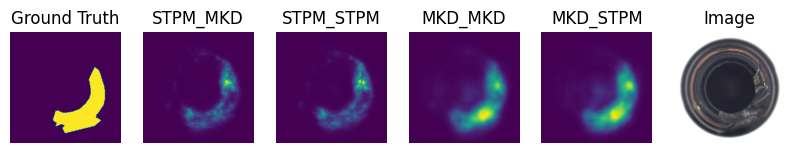

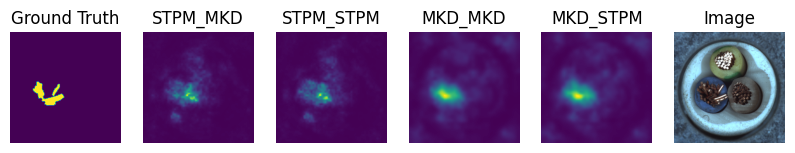

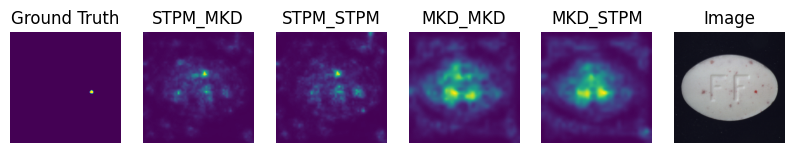

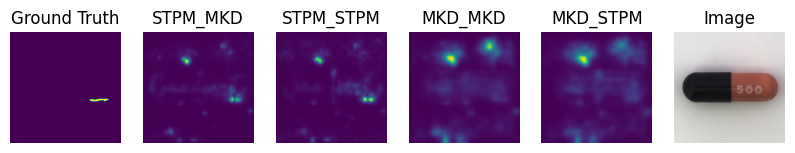

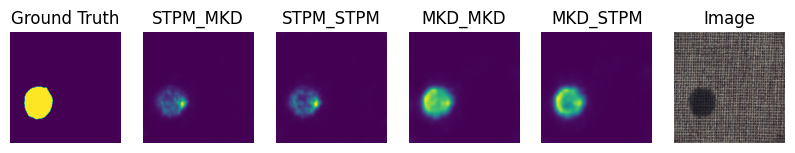

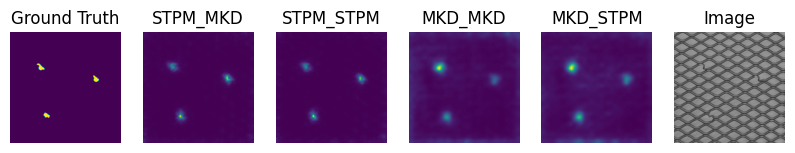

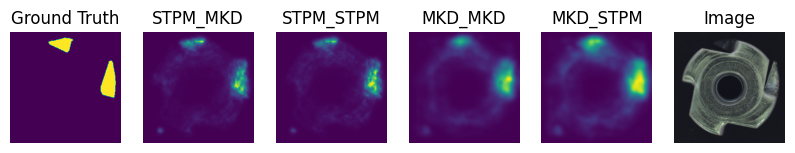

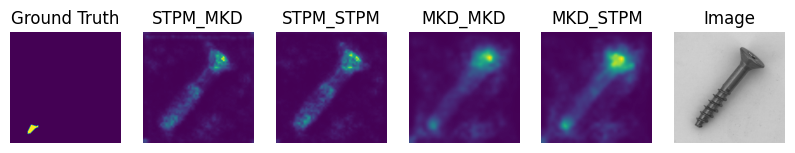

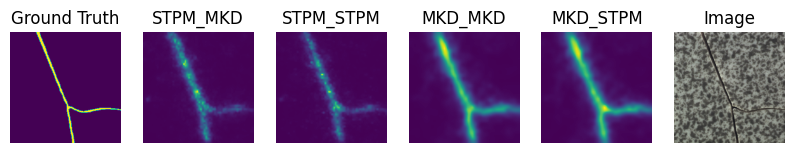

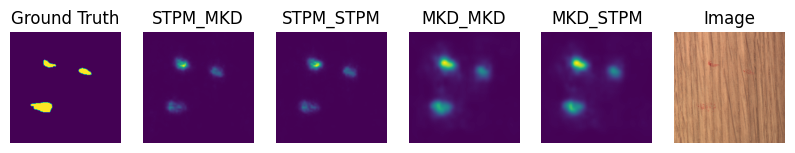

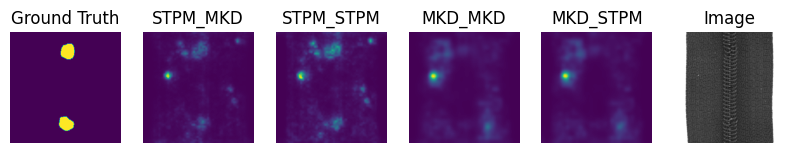

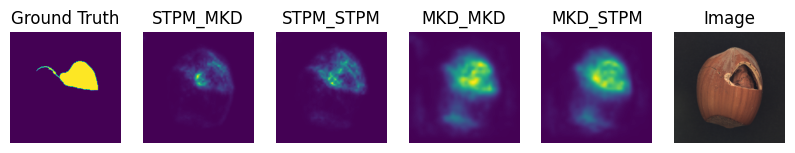

In [8]:
img_num = 0 
for class_name in ['bottle','cable','pill','capsule','carpet','grid','metal_nut','screw','tile','wood','zipper','hazelnut']:
    cfg['class'] = class_name 
    test_dirs,test_labels,test_loader,true_gt = load_data(cfg)
    
    fig,axes = plt.subplots(1,6,figsize=(10,10))
    axis_num = 1
    #img_num = 0 

    gt = true_gt[img_num]
    axes[0].imshow(gt)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    for model_name in ['STPM','MKD']:
        for loss_name in ['MKD','STPM']:
            cfg['model'] = model_name 
            cfg['loss_function'] = loss_name
            teacher,student = load_model(cfg)
            scores = scoring(teacher,student,cfg,test_loader)
            predicted = scores[img_num]

            axes[axis_num].imshow(predicted)
            axes[axis_num].set_title(f'{model_name}_{loss_name}')
            axes[axis_num].axis('off')
            axis_num +=1 

    img = cv2.imread(test_dirs[img_num])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[axis_num].imshow(img)
    axes[axis_num].axis('off')
    axes[axis_num].set_title('Image')
    plt.show()

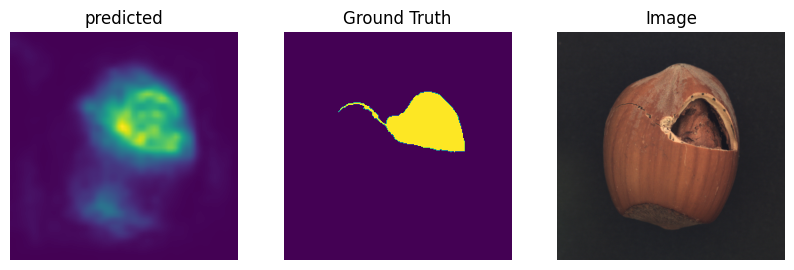

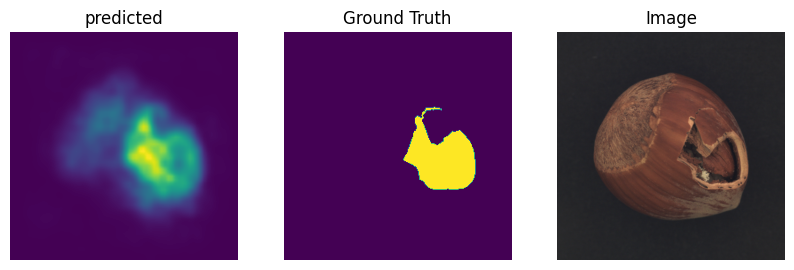

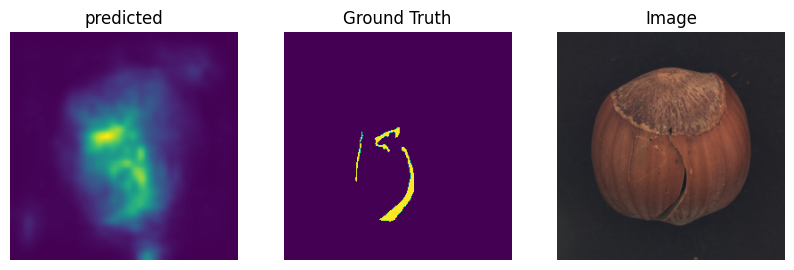

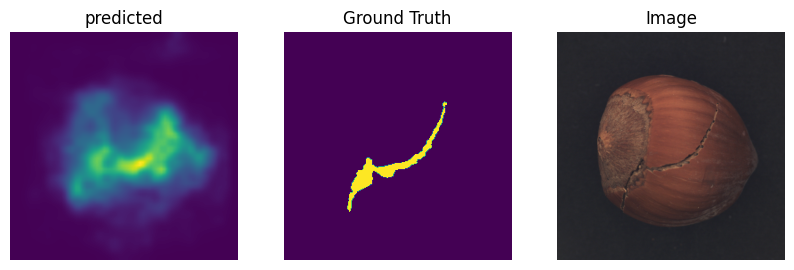

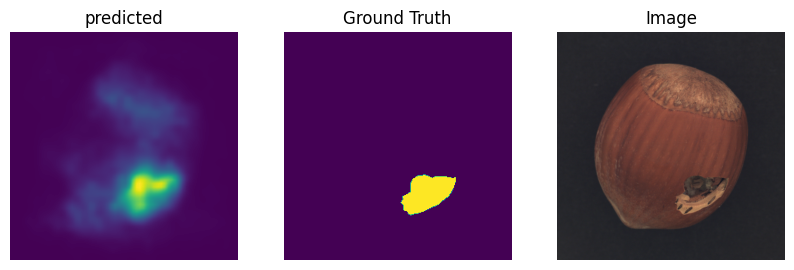

In [9]:
for i in range(5):
    predicted = scores[i]
    gt = true_gt[i]
    img = cv2.imread(test_dirs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig,axes = plt.subplots(1,3,figsize=(10,10))
    
    axes[0].imshow(predicted)
    axes[0].set_title('predicted')
    axes[0].axis('off')

    axes[1].imshow(gt)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(img)
    axes[2].axis('off')
    axes[2].set_title('Image')
    plt.show()